<a href="https://colab.research.google.com/github/tomhyhan/noodles/blob/main/pasta_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import userdata
from google.colab import auth

auth.authenticate_user()
token = userdata.get('token')
username = userdata.get('username')
repo_name = "noodles"

In [3]:
!git clone https://github.com/tomhyhan/{repo_name}.git
%cd {repo_name}
!git pull

fatal: destination path 'noodles' already exists and is not an empty directory.
/content/noodles
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 2.09 KiB | 714.00 KiB/s, done.
From https://github.com/tomhyhan/noodles
   3e3e6b9..a3c4a68  main       -> origin/main
Updating 6249cd6..a3c4a68
Fast-forward
 pasta_classification.ipynb | 242 ++++++++++++++++++++++++++++++++++++-----------------------------
 1 file changed, 133 insertions(+), 109 deletions(-)


In [4]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import sys

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "noodles"

GOOGLE_DRIVE_PATH = os.path.join("..", "drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)


In [6]:
from model.utils import test_colab
test_colab()


Hello Colab! from Noodles ha


In [7]:
!pip install torchinfo
!pip install imagehash

In [30]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold


from config.config_manager import ConfigManager
from collections import Counter
from model.data_model import PastaData, create_train_transforms, create_test_transforms
from model.train import trainer, create_model
from model.utils import reset_seed
from model.data import CLASS_ENCODER, create_csv
from model.viz import class_imbalance, draw_loss, draw_train_val_accuracy

In [31]:
config_manager = ConfigManager("./config/config.yml")

SEED = config_manager.config.seed

In [32]:
reset_seed(SEED)

In [33]:
image_path = os.path.join(GOOGLE_DRIVE_PATH, "images")
csv_file_path = os.path.join(GOOGLE_DRIVE_PATH, "pasta_data.csv")

if not os.path.exists(csv_file_path):
    create_csv(image_path, csv_file_path)

In [34]:
data = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, "./pasta_data.csv"))
image_paths, labels = data["img_path"], data["label"]

X, test_data, y, test_label = train_test_split(image_paths.values, labels.values, train_size=0.9, random_state=SEED, shuffle=True, stratify=labels)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


80 20


Epoch 1/5:   0%|          | 0/15 [00:00<?, ?it/s]

Learning Rate: [7.992922794678173e-05]
Epoch 1 Loss: 2.8245840231577555 Train Accuracy: 0.325             Validation Accuracy: 0.375


Epoch 2/5:   0%|          | 0/15 [00:00<?, ?it/s]

Learning Rate: [9.367043534921637e-05]
Epoch 2 Loss: 2.362733316421509 Train Accuracy: 0.7625             Validation Accuracy: 0.3125


Epoch 3/5:   0%|          | 0/15 [00:00<?, ?it/s]

Learning Rate: [5.819106280717461e-05]
Epoch 3 Loss: 1.4346389651298523 Train Accuracy: 0.9             Validation Accuracy: 0.4375


Epoch 4/5:   0%|          | 0/15 [00:00<?, ?it/s]

Learning Rate: [1.654380350817838e-05]
Epoch 4 Loss: 0.6874606827894847 Train Accuracy: 0.9583333333333334             Validation Accuracy: 0.4375


Epoch 5/5:   0%|          | 0/15 [00:00<?, ?it/s]

Learning Rate: [8.989315363919582e-08]
Epoch 5 Loss: 0.4490430146455765 Train Accuracy: 0.9541666666666667             Validation Accuracy: 0.4375
End of Training for swin Model 0-fold
best accuracy: 0.4375


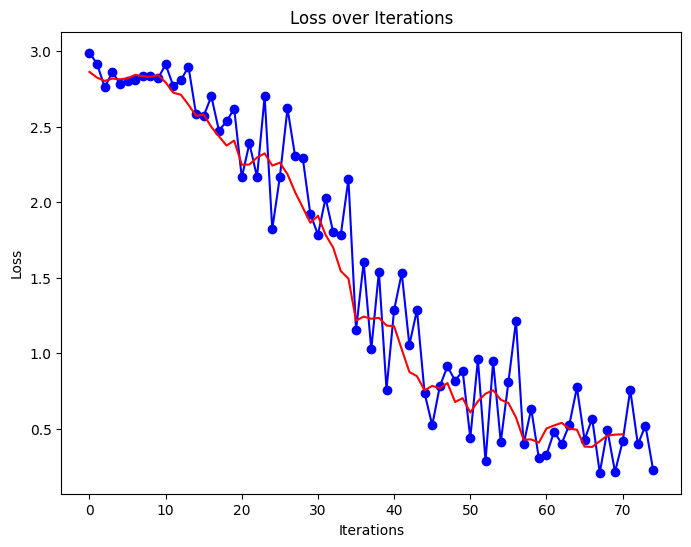

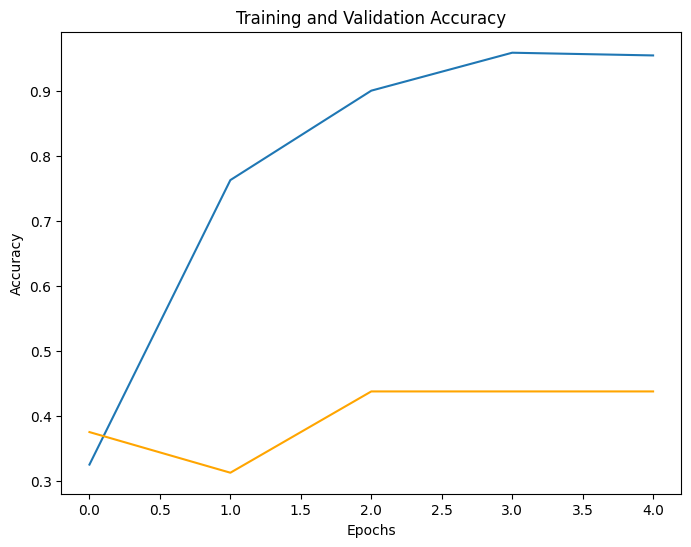

current_model_accuracies [0.4375]


In [42]:
k_fold = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
models = ['swin']

# N=100
# perm_indices = np.random.permutation(N)
# X = X[perm_indices]
# y = y[perm_indices]

for model_name in models:
    current_model_accuracies = []
    for k_id, (train_i, val_i) in enumerate(k_fold.split(X,y)):
        print(len(train_i), len(val_i))
        train_set = X[train_i]
        train_label_set = y[train_i]

        val_set = X[val_i]
        val_label_set = y[val_i]

        model_config = config_manager.config[model_name]
        lr = config_manager.config.lr
        num_epochs = config_manager.config.num_epochs
        num_classes = config_manager.config.num_classes
        batch_size = model_config.train_args.batch_size
        weight_decay = model_config.train_args.weight_decay
        log_interval = model_config.train_args.log_interval
        out_dir = model_config.train_args.output_dir
        scheduler_name = model_config.train_args.scheduler

        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        train_transform = create_train_transforms()
        test_transform = create_test_transforms()

        train_data = PastaData(train_set, train_label_set, transform_list=train_transform)
        val_data = PastaData(val_set, val_label_set, transform_list=test_transform)

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

        model = create_model(model_name, num_classes)
        model.to(device)

        #  need to make dataframe from images
        loss_history, train_accuracy_history, \
        val_accuracy_history, best_accuracy, best_params = trainer(
            model,
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            lr=lr,
            batch_size=batch_size,
            weight_decay=weight_decay,
            log_interval=log_interval,
            scheduler_name=scheduler_name,
            device=device
        )


        current_model_accuracies.append(best_accuracy)
        print(f"End of Training for {model_name} Model {k_id}-fold")
        print(f"best accuracy: {best_accuracy}")

        os.makedirs(os.path.join(GOOGLE_DRIVE_PATH, out_dir), exist_ok=True)
        torch.save(best_params, os.path.join(GOOGLE_DRIVE_PATH, out_dir, f"{model_name}_k_fold_{k_id}.pt"))
        draw_loss(loss_history)
        draw_train_val_accuracy(train_accuracy_history, val_accuracy_history)

        break

    print("current_model_accuracies", current_model_accuracies)
    break


        # avg_accuracy = torch.mean(fold_accuracies)
        # std_accuracy = torch.std(fold_accuracies)

        # general plan
        # 1. save best accuracies
        # 2. compare with different models
        # 3. train on full dataset with best performing model
        # 4. make inference


In [ ]:
# Inference

In [43]:
# !git config pull.rebase false
# !git pull
# !git config --global user.email "tomhyhan@gmail.com"
# !git config --global user.name username
# !git add .
# !git status
# !git commit -m "updated trainer"
# !git push https://{token}@github.com/{username}/{repo_name}.git

Already up to date.
On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   config/config.yml
	modified:   model/train.py
	modified:   model/viz.py

[main f95f3bb] updated trainer
 3 files changed, 66 insertions(+), 9 deletions(-)
Enumerating objects: 13, done.
Counting objects: 100% (13/13), done.
Delta compression using up to 2 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 1.49 KiB | 1.49 MiB/s, done.
Total 7 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/tomhyhan/noodles.git
   a3c4a68..f95f3bb  main -> main
